In [9]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [10]:
# SET RANGE OF THICKNESS FOR THE CONTINENTAL CRUST (IN METERS)
FROM = 30000 
TO = 60000
INCREMENT = 5000
cc = np.array(range(FROM,TO+INCREMENT,INCREMENT))

# Assumptions

In [11]:
g = 9.81 # [m/s^2]

rho_w = 1000 # density of water [kg/m^3]

# Present day Earth
rho_cc = 2850 # density of continental crust [kg/m^3]
rho_cm = 3338 # density of continental lithospheric mantle [kg/m^3]
cm = 200000 # thickness of continental  mantle [m]

rho_oc = 2919 # density of oceanic crust [kg/m^3]
rho_om = 3284 # density of depleted oceanic lithospheric mantle [kg/m^3]
oc = 7000 # thickness of oceanic crust layer [m]
om = 53000 # thickness of depleted oceanic lithospheric mantle [m]

rho_m = 3300 # density of asthenospheric mantle [kg/m^3]

# Archean Earth
rho_m_archean  = 3271 # density of asthenospheric mantle [kg/m^3]
rho_cc_archean = rho_cc # density of continental crust [kg/m^3]
rho_cm_archean = rho_m_archean-5 # density of continental lithospheric mantle [kg/m^3]
cm_archean = cm # thickness of continental  mantle [m]

rho_oc_archean = 2957 # density of oceanic crust [kg/m^3]
rho_om_archean = 3268 # density of depleted oceanic lithospheric mantle [kg/m^3]
oc_archean = 28400 # thickness of oceanic crust layer [m]
om_archean = 106500 # thickness of depleted oceanic lithospheric mantle [m]



### Isostatic balance equation
Isostatic balance equation (assume sea level = 0):

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_w w_A + \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

- $\rho_i$ is the density of water, oceanic crust, (depleted) oceanic mantle, (asthenospheric) mantle, continental crust, etc.
- $d_i$ is the thickness of the oceanic crust, continental crust, etc.
- $w_B$ is the thickness of the water layer above the oceanic lithosphere
- $w_A$ is the thickness of the water layer above the continental lithosphere.


where the compensation depth is taken as the base of the continental lithospheric mantle, which determines the depth of the asthenospheric mantle ($d_m$).

Assuming $w_A = 0$:

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

Since we have two unknowns ($d_m$ and $w_B$), we use the equation:

$$d_{cc}+d_{cm} = w_B + d_{oc} + d_{om} + d_m$$

solving for $w_B$:
$$w_B = d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}$$

substituting into the isostatic balance equation:

$$\rho_w(d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}) + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

solving for $d_m$:
$$d_m = \frac{d_{cc}(\rho_{cc} - \rho_w) + d_{cm}(\rho_{cm} - \rho_w) + d_{om}(\rho_w - \rho_{om}) + d_{oc}(\rho_w - \rho_{oc})}{\rho_m -\rho_w}$$

In [12]:
# solving for the thickness of the asthenospheric mantle (present day Earth)
m = (cc*(rho_cc-rho_w)+cm*(rho_cm-rho_w)+om*(rho_w-rho_om)+oc*(rho_w-rho_oc))\
/(rho_m-rho_w)

# solving for the thickness of the asthenospheric mantle (Archean Earth)
m_archean = (cc*(rho_cc-rho_w)+cm*(rho_cm_archean-rho_w)+om_archean*(rho_w-rho_om_archean)+oc_archean*(rho_w-rho_oc_archean))\
/(rho_m_archean-rho_w)

In [13]:
print("\nPresent day")
for i in m:
    print(f"{i/1000:.0f} km")
print("\nArchean")
for i in m_archean:
    print(f"{i/1000:.0f} km")



Present day
169 km
173 km
177 km
181 km
185 km
189 km
193 km

Archean
93 km
97 km
101 km
105 km
109 km
114 km
118 km


now solving for $w_B$:

In [14]:
w_B = cc + cm - om - m - oc
w_B_archean = cc + cm_archean - om_archean - m_archean - oc_archean

In [15]:
print("Present day")
for i in w_B:
    print(f"{i/1000:.0f} km")

print("\nArchean")
for i in w_B_archean:
    print(f"{i/1000:.0f} km")

Present day
1 km
2 km
3 km
4 km
5 km
6 km
7 km

Archean
2 km
3 km
4 km
5 km
6 km
7 km
7 km


###  Calculating the lithostatic pressure
$$P = \int_{a}^{b} \rho(z) g dz$$

#### Continental lithosphere

In [16]:
compensation_depth = cc + cm # compensation depth

initial_depth = 0
depth_increment = 1000
final_depth = compensation_depth+depth_increment
z = [[]]*len(cc)
for i, depth in enumerate(final_depth):
    z[i] = list(range(initial_depth,depth,depth_increment)) # depth [m]

In [17]:
def calc_pressure_continent(z:list, w:int, cc:int,rho_cm:int, rho_m:int):
    """
    Calculates the lithostatic pressure of the  continental lithosphere.
    z: depth
    w: thickness of the water layer above
    cc: thickness of the continental crust
    rho_cm: density of the continental lithospheric mantle
    rho_m: density of the asthenospheric mantle
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            # integrate the density over the water layer
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w + cc:
            # integrate pthe density over the crustal layer,
            # plus the total pressure from the water layer
            y, err = integrate.quad(lambda z: rho_cc*g,w,val)
            y+= rho_w*g*w
        elif w + cc <= abs(val) <= w + cc + cm:
            # integrate the density over the continental lithospheric mantle layer,
            # plus the total pressure from the water + crustal layer
            y, err = integrate.quad(lambda z: rho_cm*g,w+cc,val)
            y+= rho_w*g*w + rho_cc*g*cc
        else:
            # integrate the density over the mantle layer,
            # plus the total pressure from the water + crustal + cm layer
            y, err = integrate.quad(lambda z: rho_m*g,w+cc+cm,val)
            y+= rho_w*g*w + rho_cc*g*cc + rho_cm*g*cm
        P[i] = y/1e6
    return P

#### Oceanic lithosphere

In [18]:
def calc_pressure_ocean(z:list, w:int, oc:int, rho_oc:int, rho_om:int, rho_m:int):
    """
    Calculates the lithostatic pressure of the  continental lithosphere.
    z: depth
    w: thickness of the water layer above
    oc: thickness of the oceanic crust
    rho_oc: density of the oceanic crust
    rho_om: density of the depleted oceanic mantle
    rho_m: density of the asthenospheric mantle
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w+oc:
            y, err = integrate.quad(lambda z: rho_oc*g,w,val)
            y+= rho_w*g*w
        elif w+oc < abs(val) <= w+oc+om:
            y, err = integrate.quad(lambda z: rho_om*g,w+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc
        else:
            y, err = integrate.quad(lambda z: rho_m*g,w+om+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc + rho_om*g*om
        P[i] = y/1e6
    return P

### Present day Earth

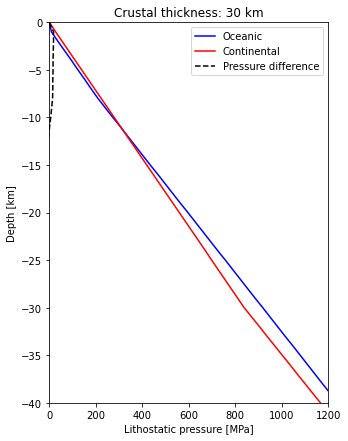

Maximum pressure difference: 18 MPa


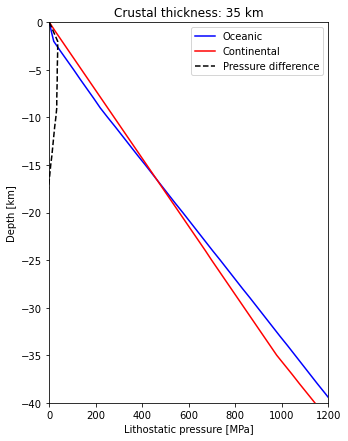

Maximum pressure difference: 36 MPa


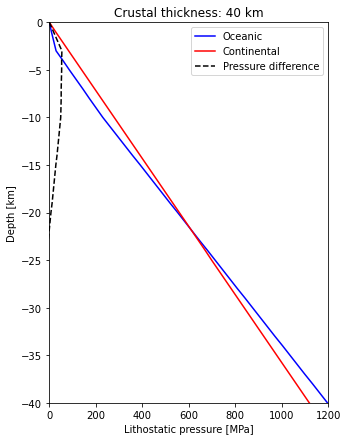

Maximum pressure difference: 54 MPa


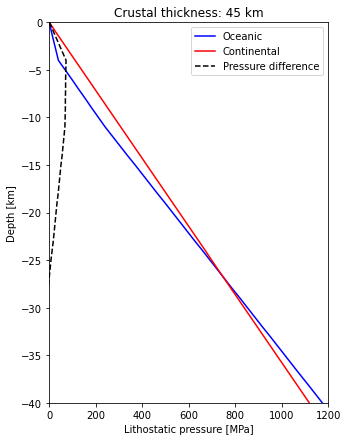

Maximum pressure difference: 72 MPa


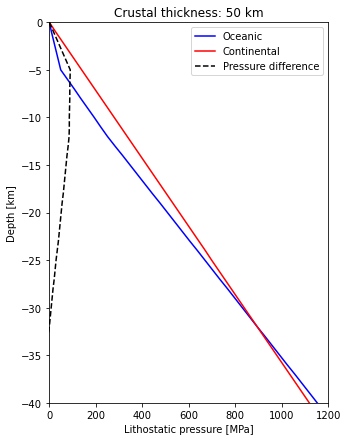

Maximum pressure difference: 90 MPa


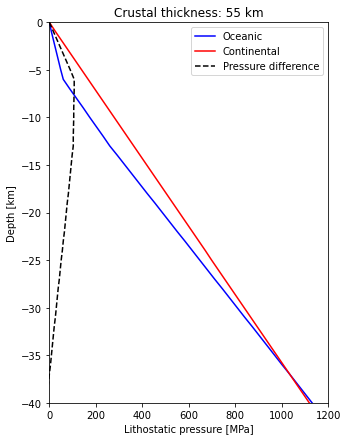

Maximum pressure difference: 107 MPa


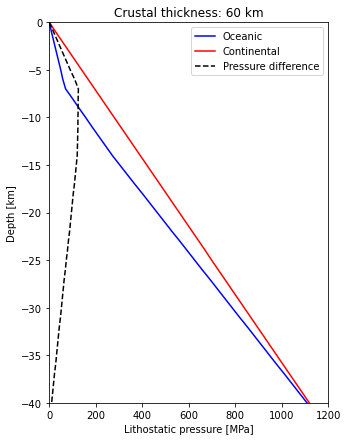

Maximum pressure difference: 125 MPa


In [19]:
# assuming that continents are at sea level
w_A = 0
P_A, P_B, P_diff = ([[]]*len(cc) for i in range(3))

for i, c in enumerate(cc):
    P_A[i] = calc_pressure_continent(z[i], w_A, c, rho_cm, rho_m)
    P_B[i] = calc_pressure_ocean(z[i], w_B[i], oc, rho_oc, rho_om, rho_m)
    plt.figure(figsize=(5,7))
    plt.plot(P_B[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A[i],[-j/1000 for j in z[i]],'r-')
    P_diff[i] = P_A[i]-P_B[i] 
    plt.plot(P_diff[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff[i]))

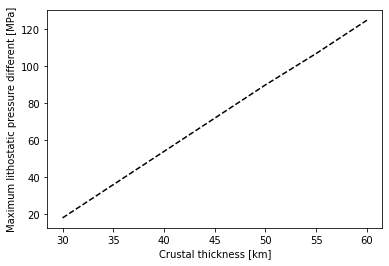

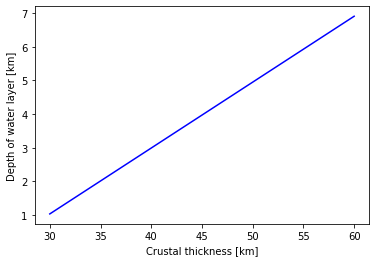

In [20]:
P_diff_max = []*len(cc)

for i in P_diff:
    P_diff_max.append(max(i))
    # print(P_diff_max)
plt.plot(cc/1000,np.array(P_diff_max),'k--')
plt.ylabel('Maximum lithostatic pressure different [MPa]')
plt.xlabel('Crustal thickness [km]')
plt.show()

plt.plot(cc/1000,w_B/1000,'b')
plt.ylabel('Depth of water layer [km]')
plt.xlabel('Crustal thickness [km]')
plt.show()

### Archean Earth

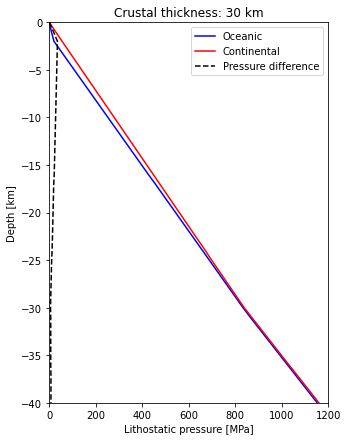

Maximum pressure difference: 35 MPa


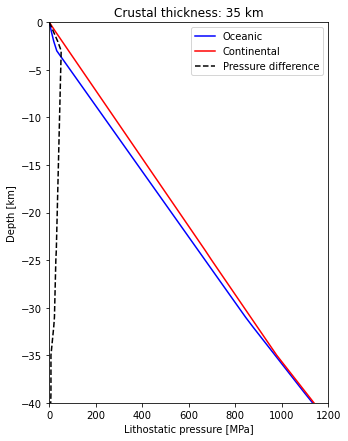

Maximum pressure difference: 51 MPa


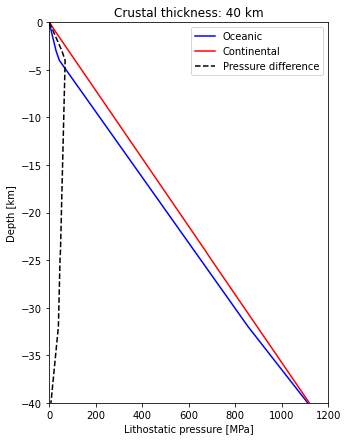

Maximum pressure difference: 68 MPa


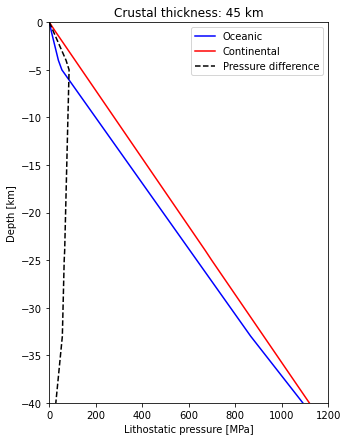

Maximum pressure difference: 85 MPa


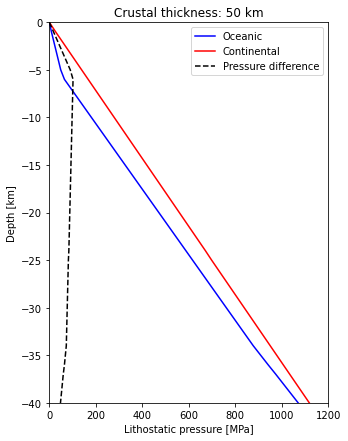

Maximum pressure difference: 102 MPa


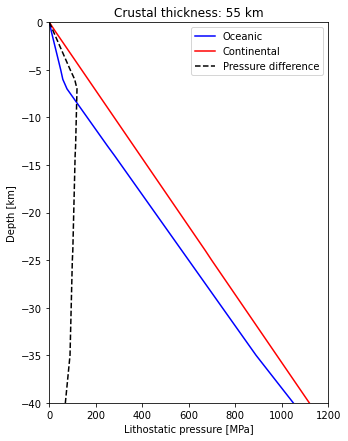

Maximum pressure difference: 119 MPa


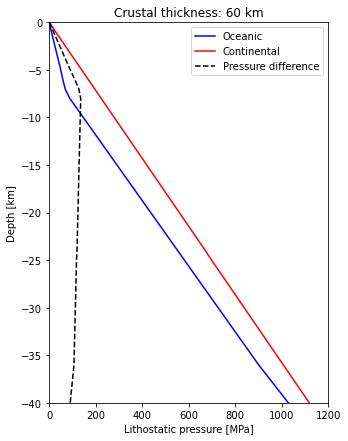

Maximum pressure difference: 135 MPa


In [21]:
# assuming that continents are at sea level
P_A_archean, P_B_archean, P_diff_archean = ([[]]*len(cc) for i in range(3))

for i, c in enumerate(cc):
    P_A_archean[i] = calc_pressure_continent(z[i], w_A, c, rho_cm_archean, rho_m_archean)
    P_B_archean[i] = calc_pressure_ocean(z[i], w_B_archean[i], oc_archean, rho_oc_archean, rho_om_archean, rho_m_archean)
    plt.figure(figsize=(5,7))
    plt.plot(P_B_archean[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A_archean[i],[-j/1000 for j in z[i]],'r-')
    P_diff_archean[i] = P_A_archean[i]-P_B_archean[i] 
    plt.plot(P_diff_archean[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff_archean[i]))

In [22]:
# saving just the continental thickness value for which there is a positive pressure difference
# zipping 2 lists into tuples, so differential pressures are associated with their respective continential thickness
P_archean = [i for i in list(map(lambda x, y:(x,y), P_diff_archean, cc)) if i[:][0][1]>0]

data_P = [list(map(lambda x, y:(x,y), P_diff, cc)), P_archean]

%store data_P
del data_P

Stored 'data_P' (list)
